In [1]:
import pickle
from deepmol.loaders import CSVLoader

def generate_results_cv(pipeline):
    f1_score_results = []
    precision_score_results = []
    recall_score_results = []
    for i in range(5):
        # read pickle file
        with open(f'./cv_data/dataset_trn_cv_{i}.pickle', 'rb') as f:
            train_cv_data = pickle.load(f)
        with open(f'./cv_data/dataset_tst_cv_{i}.pickle', 'rb') as f:
            test_cv_data = pickle.load(f)

        field_task15 = ['Anthranilate',
                    'Cholesterol',
                    'GGPP',
                    'Indole.3',
                    'IPP',
                    'L.Ala',
                    'L.Arg',
                    'L.Asp',
                    'L.His',
                    'L.Lys',
                    'L.Phe',
                    'L.Pro',
                    'L.Trp',
                    'L.Tyr',
                    'Secologanin']
        data_path = "cv_data/alkaloid_data.csv"
        dataset = CSVLoader(data_path, smiles_field='SMILES', labels_fields=field_task15, id_field='CID').create_dataset()
        train_cv_data = dataset.select(train_cv_data, inplace=False)
        test_cv_data = dataset.select(test_cv_data, inplace=False)

        #fit the pipeline
        pipeline.fit(train_cv_data)
        from sklearn.metrics import f1_score, precision_score, recall_score
        from deepmol.metrics import Metric


        def macro_f1_score(y_true, y_pred):
            return f1_score(y_true, y_pred, average='macro')

        def macro_precision_score(y_true, y_pred):
            return precision_score(y_true, y_pred, average='macro')

        def macro_recall_score(y_true, y_pred):
            return recall_score(y_true, y_pred, average='macro')


        results_test = pipeline.evaluate(test_cv_data, metrics=[Metric(macro_f1_score), Metric(macro_precision_score), Metric(macro_recall_score)], per_task_metrics=False)
        f1_score_results.append(results_test[0]["macro_f1_score"])
        precision_score_results.append(results_test[0]["macro_precision_score"])
        recall_score_results.append(results_test[0]["macro_recall_score"])
    return f1_score_results, precision_score_results, recall_score_results

In [2]:
from deepmol.pipeline import Pipeline

from deepmol.scalers import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint, TwoDimensionDescriptors, LayeredFingerprint
from deepmol.standardizer import ChEMBLStandardizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")


pipeline_layered_fingerprints_baseline_ridge_classifier = Pipeline(steps=[('layered fingerprints', LayeredFingerprint()),
                                                                           ('ridge classifier', SklearnModel(model=RidgeClassifier(random_state=42)))])


pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')

2024-03-22 17:27:39.739666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:27:39.837807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 17:27:39.837876: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 17:27:39.837935: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 17:27:39.853601: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 17:27:39.854467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
from deepmol.pipeline import Pipeline


pipeline_285_results = generate_results_cv(pipeline_285)
pipeline_layered_fingerprints_baseline_ridge_classifier_results = generate_results_cv(pipeline_layered_fingerprints_baseline_ridge_classifier)
pipeline_morgan_fp_results = generate_results_cv(pipeline_morgan_fp)


2024-03-22 17:27:46,399 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:27:53,543 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:27:59,946 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:28:08,359 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:28:16,768 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:28:24,810 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:28

In [4]:
import numpy as np

mf1_score_pipeline_285 = np.mean(np.array(pipeline_285_results[0]))
mprecision_score_pipeline_285 = np.mean(np.array(pipeline_285_results[1]))
mrecall_score_pipeline_285 = np.mean(np.array(pipeline_285_results[2]))
mf1_score_pipeline_285, mprecision_score_pipeline_285, mrecall_score_pipeline_285

(0.8937952296265829, 0.9372874695998998, 0.8719492563102211)

In [5]:
import os

import numpy as np

results = os.listdir('./mgcnn_results/')

mf1_scores = []
mprecision_scores = []
mrecall_scores = []
for result in results:
    if "f1_score" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_f1_scores = f.readlines()
            for i in range(len(mgcnn_f1_scores)):
                mgcnn_f1_scores[i] = float(mgcnn_f1_scores[i].strip())
        mf1_scores.append(np.mean(np.array(mgcnn_f1_scores)))
    elif "precision" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_precision_scores = f.readlines()
            for i in range(len(mgcnn_precision_scores)):
                mgcnn_precision_scores[i] = float(mgcnn_precision_scores[i].strip())
        mprecision_scores.append(np.mean(np.array(mgcnn_precision_scores)))
    elif "recall" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_recall_scores = f.readlines()
            for i in range(len(mgcnn_recall_scores)):
                mgcnn_recall_scores[i] = float(mgcnn_recall_scores[i].strip())
        mrecall_scores.append(np.mean(np.array(mgcnn_recall_scores)))

In [6]:
color_map = {'Layered FP + Low Variance FS + Ridge Classifier': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Layered FP + Ridge Classifier': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Morgan FP + Ridge Classifier': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Morgan FP + MLP': (0.8352941176470589, 0.3686274509803922, 0.0),
 'MGCNN (Eguchi et al. 2019)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'Morgan FP + Random Forest': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'Morgan FP + KNN': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'Descriptors + Random Forest': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451) }

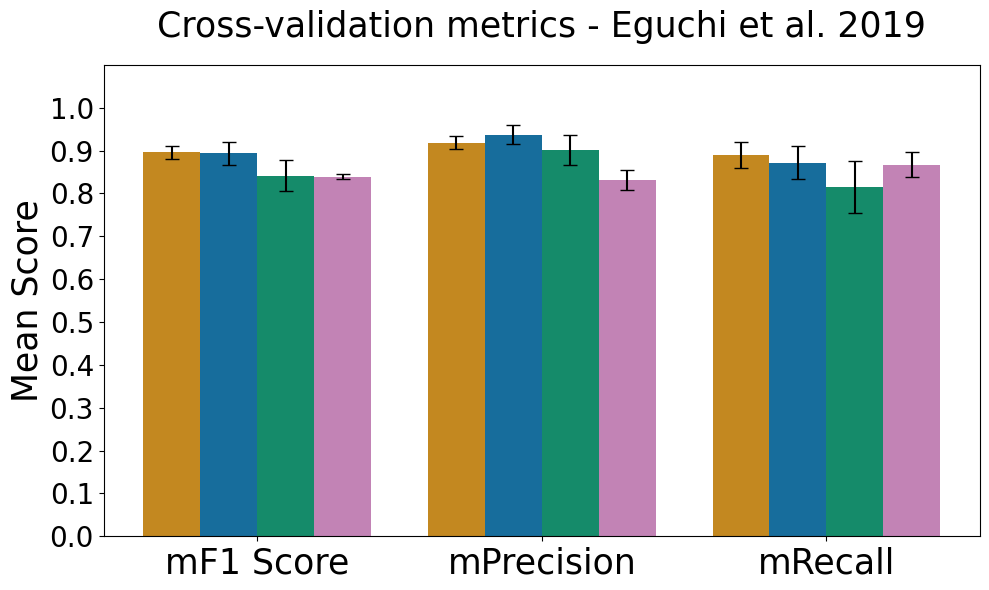

In [7]:
# Creating a DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.transparent'] = True


# convert to numpy array
mf1_scores = np.array(mf1_scores)
mprecision_scores = np.array(mprecision_scores)
mrecall_scores = np.array(mrecall_scores)

data = {
    'Metric': ['mF1 Score', 'mPrecision', 'mRecall'] * 4,
    'Mean Score': [
        np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[0]).mean(), np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[1]).mean(), np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[2]).mean(),
        np.array(pipeline_285_results[0]).mean(), np.array(pipeline_285_results[1]).mean(), np.array(pipeline_285_results[2]).mean(),
        np.array(pipeline_morgan_fp_results[0]).mean(), np.array(pipeline_morgan_fp_results[1]).mean(), np.array(pipeline_morgan_fp_results[2]).mean(),
        mf1_scores.mean(), mprecision_scores.mean(), mrecall_scores.mean(),
    ],
    'STD': [
        np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[0]).std(), np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[1]).std(), np.array(pipeline_layered_fingerprints_baseline_ridge_classifier_results[2]).std(),
        np.array(pipeline_285_results[0]).std(), np.array(pipeline_285_results[1]).std(), np.array(pipeline_285_results[2]).std(),
        np.array(pipeline_morgan_fp_results[0]).std(), np.array(pipeline_morgan_fp_results[1]).std(), np.array(pipeline_morgan_fp_results[2]).std(),
        mf1_scores.std(), mprecision_scores.std(), mrecall_scores.std(),

    ],
    'Model':  ['Layered FP + Ridge Classifier'] * 3 + ['Layered FP + Low Variance FS + Ridge Classifier'] * 3 + ['Morgan FP + Ridge Classifier'] * 3 + 
['MGCNN (Eguchi et al. 2019)'] * 3 
    
}

df = pd.DataFrame(data)

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=df, x='Metric', y='Mean Score', hue='Model', palette=color_map, legend=False)

# Iterate over the bars, adding error bars
for i, patch in enumerate(barplot.patches):
    # Get the x-coordinate of the bar's center
    if patch.get_height() != 0:
        x = patch.get_x() + patch.get_width() / 2
        # Get the corresponding standard deviation from the DataFrame
        std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # Add error bar for this bar using plt.errorbar
        plt.errorbar(x, patch.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(patch.get_height(), '.3f'),  # Text to display
        #                 (patch.get_x() +patch.get_width() / 2., patch.get_height() + std/2 + 0.08),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('Cross-validation metrics - Eguchi et al. 2019', pad=20, size=25)
plt.ylabel('Mean Score', size=25)
plt.xlabel('')
#plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)  # Extend y-axis limit
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)
plt.xticks(size=25)
plt.tight_layout()
plt.savefig('cross_validation_metrics_eguchi_et_al_2019.png', dpi=400)

In [8]:
import pickle
from deepmol.loaders import CSVLoader

def generate_results_cv_for_statistics(pipeline, model_name):
    f1_score_results = []
    precision_score_results = []
    recall_score_results = []
    subject = []
    model_name_ = []
    for i in range(5):
        # read pickle file
        with open(f'./cv_data/dataset_trn_cv_{i}.pickle', 'rb') as f:
            train_cv_data = pickle.load(f)
        with open(f'./cv_data/dataset_tst_cv_{i}.pickle', 'rb') as f:
            test_cv_data = pickle.load(f)

        field_task15 = ['Anthranilate',
                    'Cholesterol',
                    'GGPP',
                    'Indole.3',
                    'IPP',
                    'L.Ala',
                    'L.Arg',
                    'L.Asp',
                    'L.His',
                    'L.Lys',
                    'L.Phe',
                    'L.Pro',
                    'L.Trp',
                    'L.Tyr',
                    'Secologanin']
        data_path = "cv_data/alkaloid_data.csv"
        dataset = CSVLoader(data_path, smiles_field='SMILES', labels_fields=field_task15, id_field='CID').create_dataset()
        train_cv_data = dataset.select(train_cv_data, inplace=False)
        test_cv_data = dataset.select(test_cv_data, inplace=False)

        #fit the pipeline
        pipeline.fit(train_cv_data)
        from sklearn.metrics import f1_score, precision_score, recall_score
        from deepmol.metrics import Metric


        predictions = pipeline.predict(test_cv_data)
        y_true = test_cv_data.y
        y_pred = predictions
        for task in range(y_true.shape[1]):
            f1_score_results.append(f1_score(y_true[:, task], y_pred[:, task]))
            precision_score_results.append(precision_score(y_true[:, task], y_pred[:, task]))
            recall_score_results.append(recall_score(y_true[:, task], y_pred[:, task]))
            subject.append(f'cv_{i}_task_{task}')
            model_name_.append(model_name)
    

    return pd.DataFrame({"model name": model_name,'f1_score': f1_score_results, 'precision_score': precision_score_results, 'recall_score': recall_score_results, 'subject': subject})

In [9]:
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_layered_fingerprints_baseline_ridge_classifier, pipeline_285, pipeline_morgan_fp], pipeline_names):
    print(name)
    results_ = generate_results_cv_for_statistics(pipeline, name)
    results = pd.concat([results, results_], axis=0)

Layered FP + Low Variance FS + Ridge Classifier
2024-03-22 17:29:16,612 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:29:26,277 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:29:33,308 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:29:41,208 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-22 17:29:49,154 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
Layered FP + Ridge Classifier
2024-03-22 17:29:56,404 — INFO — Assuming multitask since y has more than one dimension. If otherwise,

In [10]:
results.iloc[10:, :]

,model name,f1_score,precision_score,recall_score,subject
10,Layered FP + Low Variance FS + Ridge Classifier,0.333333,0.250000,0.500000,cv_0_task_10
11,Layered FP + Low Variance FS + Ridge Classifier,0.962963,0.928571,1.000000,cv_0_task_11
12,Layered FP + Low Variance FS + Ridge Classifier,0.988764,1.000000,0.977778,cv_0_task_12
13,Layered FP + Low Variance FS + Ridge Classifier,0.986301,1.000000,0.972973,cv_0_task_13
14,Layered FP + Low Variance FS + Ridge Classifier,0.972973,1.000000,0.947368,cv_0_task_14
...,...,...,...,...,...
70,Morgan FP + Ridge Classifier,0.571429,1.000000,0.400000,cv_4_task_10
71,Morgan FP + Ridge Classifier,0.818182,0.750000,0.900000,cv_4_task_11
72,Morgan FP + Ridge Classifier,0.904110,0.942857,0.868421,cv_4_task_12
73,Morgan FP + Ridge Classifier,0.962963,0.975000,0.951220,cv_4_task_13


In [11]:
import os

import numpy as np
import re

mgcnn_results = os.listdir('./mgcnn_results/')

f1_scores = []
precision_scores = []
recall_scores = []
subject = []
for result in mgcnn_results:
    if "f1_score" in result:
        number = re.findall(r'\d+', result)[1]
    else:
        number = re.search(r'\d+', result).group()
    if "f1_score" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_f1_scores = f.readlines()
            # identify the number in path with a regex
                
            for i in range(len(mgcnn_f1_scores)):
                f1_scores.append(float(mgcnn_f1_scores[i].strip()))
                subject.append(f'cv_{number}_task_{i}')

    elif "precision" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_precision_scores = f.readlines()
            for i in range(len(mgcnn_precision_scores)):
                precision_scores.append(float(mgcnn_precision_scores[i].strip()))

    elif "recall" in result:
        with open(f'./mgcnn_results/{result}', 'r') as f:
            mgcnn_recall_scores = f.readlines()
            for i in range(len(mgcnn_recall_scores)):
                recall_scores.append(float(mgcnn_recall_scores[i].strip()))

results = pd.concat([results, pd.DataFrame({"model name": ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores),'f1_score': f1_scores, 'precision_score': precision_scores, 'recall_score': recall_scores, 'subject': subject})], axis=0)

In [12]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['model name'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['model name'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Low Variance FS + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 3.0074174224408058e-06
Significant difference between Layered FP + Low Variance FS + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 2.8478320955765245e-05
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 5.219185010859611e-06
Significant difference between Layered FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.00026126929805578926


In [13]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['model name'] == pipeline1)]['recall_score']
    f1_scores2 = results[(results['model name'] == pipeline2)]['recall_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Low Variance FS + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 2.6217779589420306e-06
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.0001928054843414454
Significant difference between Morgan FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.009810567879106384


In [14]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['model name'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['model name'] == pipeline1)]['precision_score']
    f1_scores2 = results[(results['model name'] == pipeline2)]['precision_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Low Variance FS + Ridge Classifier and Layered FP + Ridge Classifier with p-value 0.012914777420206918
Significant difference between Layered FP + Low Variance FS + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 2.5273053872485577e-06
Significant difference between Layered FP + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.013495240558764138
Significant difference between Layered FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 1.9802517299013524e-07
Significant difference between Morgan FP + Ridge Classifier and MGCNN (Eguchi et al. 2019) with p-value 0.00034194239603548005


In [15]:
for diff in significant_differences_f1:
    print(f"{diff[0]} vs {diff[1]}: {diff[2]}")

Layered FP + Low Variance FS + Ridge Classifier vs Layered FP + Ridge Classifier: 0.012914777420206918
Layered FP + Low Variance FS + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 2.5273053872485577e-06
Layered FP + Ridge Classifier vs Morgan FP + Ridge Classifier: 0.013495240558764138
Layered FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 1.9802517299013524e-07
Morgan FP + Ridge Classifier vs MGCNN (Eguchi et al. 2019): 0.00034194239603548005


In [16]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [17]:
# generate a table with significant differences
significant_differences = significant_differences_f1
# transform p-values to asterisks
significant_differences = [(pipeline1, pipeline2, convert_pvalue_to_asterisks(pvalue)) for pipeline1, pipeline2, pvalue in significant_differences]

significant_differences_df = pd.DataFrame(significant_differences, columns=["Pipeline 1", "Pipeline 2", "Differences (F1 score)"])
significant_differences_df.to_csv("significant_differences.csv", index=False)

In [18]:
color_map = {'Layered FP + Low Variance FS + Ridge Classifier': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Layered FP + Ridge Classifier': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Morgan FP + Ridge Classifier': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Morgan FP + MLP': (0.8352941176470589, 0.3686274509803922, 0.0),
 'MGCNN (Eguchi et al. 2019)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'Morgan FP + Random Forest': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'Morgan FP + KNN': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'Descriptors + Random Forest': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451) }

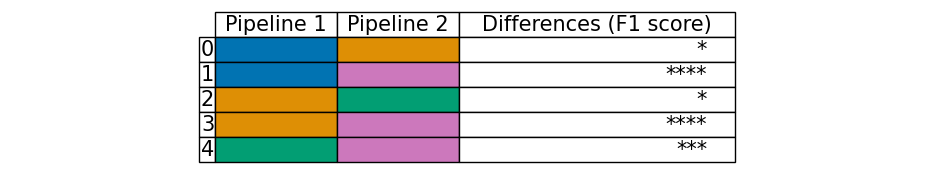

In [19]:
# save the table to a svg but still with the colors in the color_map
from pandas.plotting import table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame
tabla = table(ax, significant_differences_df, loc='center', colWidths=[0.1, 0.1, 0.1])  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(15) # if ++fontsize is necessary ++colWidths
tabla.scale(1.5, 1.5) # change size table
# hide the index
tabla.auto_set_column_width([0, 1, 2])

# apply the colors to the table
for i in range(len(significant_differences_df.columns)-1):
    for j, value in enumerate(significant_differences_df[significant_differences_df.columns[i]]):
        j+=1
        tabla[(j, i)].set_facecolor(color_map[value])
        tabla[(j, i)].set_text_props(text='')
        tabla[(j, i)].set_edgecolor('black')


plt.savefig('significant_differences.svg', transparent=True, dpi=400)


In [20]:
import pingouin as pg

pg.friedman(data=results, dv="f1_score", within="model name", subject="subject")

,Source,W,ddof1,Q,p-unc
Friedman,model name,0.139872,3,31.471264,6.763850e-07


In [21]:
# apply the wilcoxon test to all pairs of pipelines
import itertools
import scipy.stats as stats


df = pd.DataFrame(f1_scores, columns=labels_names, index=pipeline_names)

significant_differences_f1 = []
for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    p_value = stats.wilcoxon(df.loc[pipeline1, :], df.loc[pipeline2, :]).pvalue
    if p_value < 0.05:
        significant_differences_f1.append((pipeline1, pipeline2, "macro_f1_score", p_value))
                       

NameError: name 'labels_names' is not defined